These are some basic utility functions we will need. 

In [2]:
# This needs to be cleaned up

import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups 
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier  #Just in case
from sklearn.ensemble import BaggingClassifier #The bagging
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import nltk
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from scipy import interp
%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Some functions for splitting data

In [3]:
def split_data(data, prob):
    """split data into fractions [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

# NAIVE BAYES

## Naive Bayes from Scratch

First, let's build a Naive Bayes classifier from scratch. This example drawn from *Data Science from Scratch* by Joel Grus. 

### Mathematical Preliminaries

Recall the key independence assumption of Naive Bayes: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$

To be concrete, let's assume we are building a spam filter. 

Given a vocabulary $w_1,\dots,w_n$, let $X_i$ be the event "message contains $w_i$." $X_i = x_i, x_i \in \{0,1\}$. 

$S$ is the event "message is spam" and $\neg S$ is the event "message is not spam."

According to Bayes' Theorem 

$P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n)} = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)P(S)\, + \,P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)P(\neg S)}$

We further assume that we have no knowledge of the prior probability of spam; so $P(S) = P(\neg S) = 0.5$ (this is the principle of indifference)

With this simplification, $P(S\,|\,X_1 = x_1,\dots, X_n = x_n) = \frac{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)}{P(X_1 = x_1,\dots, X_n = x_n\,|\,S)\, +\, P(X_1 = x_1,\dots, X_n = x_n\,|\,\neg S)}$ 

Now we make the Naive Bayes assumption: $P(X_1 = x_1,\dots,X_n = x_n\,|\,S) = P(X_1 = x_1\,|\,S)\times \dots 
    \times P(X_n = x_n\,|\,S)$
    
We can estimate $P(X_i = x_i\,|\,S)$ by computing the fraction of spam messages containing the word $i$, e.g., Obamacare. 

Smoothing: $P(X_i\,|\,S) = \frac{(k + \textrm{number of spams containing}\, w_i)}{(2k + \textrm{number of spams})}$



### Now we are going to code this up

Lets start with spam detection, we have data from: https://spamassassin.apache.org/publiccorpus/ in `data/Spam_Data` with the spam in `data/Spam_Data/spam` and the non spam in `data/Spam_Data/not_spam`

In [4]:
def loadEmailDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    # regex for stripping out the leading "Subject:" and any spaces after it
    subject_regex = re.compile(r"^Subject:\s+")
    
    #The dict that will become the DataFrame
    emailDict = {
        'category' : [],
        'text' : [],
    }
    for fPath in filePaths:
        with open(fPath, errors='surrogateescape') as f:
            for line in f:
                if line.startswith("Subject:"):
                    #Could also save the subject field
                    subject = subject_regex.sub("", line).strip()
                    emailDict['text'].append(subject)
    emailDict['category'] = [category] * len(emailDict['text'])
    return pandas.DataFrame(emailDict)

spamDF = loadEmailDir('data/Spam_Data/spam', 'spam')
spamDF = spamDF.append(loadEmailDir('data/Spam_Data/not_spam', 'not spam'), ignore_index= True)
spamDF['is_spam'] = [c == 'spam' for c in spamDF['category']]
spamDF[:10]

,category,text,is_spam
0,spam,Life Insurance - Why Pay More?,True
1,spam,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,True
2,spam,Guaranteed to lose 10-12 lbs in 30 days ...,True
3,spam,Re: Fw: User Name & Password to Membership To ...,True
4,spam,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,True
5,spam,RE: Your Bank Account Information,True
6,spam,"FORTUNE 500 COMPANY HIRING, AT HOME REPS.",True
7,spam,Is Your Family Protected?,True
8,spam,RE: Important Information Concerning Your Bank...,True
9,spam,MULTIPLY YOUR CUSTOMER BASE!,True


We can now tokenize and normalize like normal

In [5]:
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

spamDF['tokenized_emails'] = spamDF['text'].apply(lambda x: nltk.word_tokenize(x))
spamDF['normalized_emails'] = spamDF['tokenized_emails'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Now we need to count the number of times each word shows up in spam and non-spam

In [6]:
spamDF

,category,text,is_spam,tokenized_emails,normalized_emails
0,spam,Life Insurance - Why Pay More?,True,"[Life, Insurance, -, Why, Pay, More, ?]","[life, insur, whi, pay]"
1,spam,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,True,"[[, ILUG, ], Guaranteed, to, lose, 10-12, lbs,...","[ilug, guarante, lose, lbs, day]"
2,spam,Guaranteed to lose 10-12 lbs in 30 days ...,True,"[Guaranteed, to, lose, 10-12, lbs, in, 30, day...","[guarante, lose, lbs, day]"
3,spam,Re: Fw: User Name & Password to Membership To ...,True,"[Re, :, Fw, :, User, Name, &, Password, to, Me...","[fw, user, name, password, membership, site, z..."
4,spam,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,True,"[[, ILUG-Social, ], re, :, Guaranteed, to, los...","[guarante, lose, lbs, day]"
5,spam,RE: Your Bank Account Information,True,"[RE, :, Your, Bank, Account, Information]","[bank, account, inform]"
6,spam,"FORTUNE 500 COMPANY HIRING, AT HOME REPS.",True,"[FORTUNE, 500, COMPANY, HIRING, ,, AT, HOME, R...","[fortun, compani, hire, home, rep]"
7,spam,Is Your Family Protected?,True,"[Is, Your, Family, Protected, ?]","[famili, protect]"
8,spam,RE: Important Information Concerning Your Bank...,True,"[RE, :, Important, Information, Concerning, Yo...","[import, inform, concern, bank, account]"
9,spam,MULTIPLY YOUR CUSTOMER BASE!,True,"[MULTIPLY, YOUR, CUSTOMER, BASE, !]","[multipli, custom, base]"


In [7]:
def count_words(traingDF, trainingColumn, tokensName):
    counts = collections.defaultdict(lambda: [0, 0])
    for index, row in traingDF.iterrows():
        for word in row[trainingColumn]:
            if row[tokensName]:
                counts[word][0] += 1
            else:
                counts[word][1] += 1
    return counts
wordCounts = count_words(spamDF, 'normalized_emails', 'is_spam')
wordCounts['cancel']

[0, 2]

We need a function to convert these counts into (smoothed) probabilities

In [8]:
def word_probabilities(counts, total_spams, total_non_spams, k=0.5):
    """turn the word_counts into a list of triplets 
    w, p(w | spam) and p(w | ~spam)"""
    return [(w,
             (spam + k) / (total_spams + 2 * k),
             (non_spam + k) / (total_non_spams + 2 * k))
             for w, (spam, non_spam) in counts.items()] 

Now we need to come up with a way to compute the spam probability for a message, given word probabilities. With the Naive Bayes assumption, we *would* be multiplying together a bunch of probabilities. This is bad (underflow) so we compute:

$p_1 *\dots*p_n = \exp(\, \log(p_1) + \dots + \log(p_n)\,)$; recall $\log(ab) = \log a + \log b$ and $\exp(\, \log x \,) = x$

Thank you, John Napier (1550-1617)

In [9]:
def spam_probability(word_probs, message_words):
    #message_words = tokenize(message)
    log_prob_if_spam = log_prob_if_not_spam = 0.0 #Initialize; we are working with log probs to deal with underflow.

    for word, prob_if_spam, prob_if_not_spam in word_probs: #We iterate over all possible words we've observed

        # for each word in the message, 
        # add the log probability of seeing it 
        if word in message_words:
            log_prob_if_spam += math.log(prob_if_spam) #This is prob of seeing word if spam
            log_prob_if_not_spam += math.log(prob_if_not_spam) #This is prob of seeing word if not spam

        # for each word that's not in the message
        # add the log probability of _not_ seeing it
        else:
            log_prob_if_spam += math.log(1.0 - prob_if_spam)
            log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
    P = 1/(1 + math.exp(log_prob_if_not_spam - log_prob_if_spam))
    #prob_if_spam = math.exp(log_prob_if_spam) #Compute numerator
    #prob_if_not_spam = math.exp(log_prob_if_not_spam)
    #return prob_if_spam / (prob_if_spam + prob_if_not_spam) #Compute whole thing and return
    return P

Think: how would this change if $P(S) \neq P(\neg S)$

Now we write a class (this is a Python term) for our Naive Bayes Classifier

In [10]:
class NaiveBayesClassifier:

    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = [] #Initializes word_probs as an empty list, sets a default smoothing parameters

    def train(self, training_set, trainingColumn, textColumn): #Operates on the training_set
    
        # count spam and non-spam messages: first step of training
        num_spams = len(training_set[training_set[trainingColumn] == True])
        num_non_spams = len(training_set[training_set[trainingColumn] == False])

        # run training data through our "pipeline"
        word_counts = count_words(training_set, textColumn, trainingColumn)
        self.word_probs = word_probabilities(word_counts, 
                                             num_spams, 
                                             num_non_spams,
                                             self.k) #"Train" classifier 
                                             
    def classify(self, message):
        return spam_probability(self.word_probs, message) #Now we have all we need to classify a message


To train the model, we'll need to split our data into training & test

In [11]:
random.seed(0)
shuffledSpamDF = spamDF.reindex(np.random.permutation(spamDF.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffledSpamDF))
train_data = shuffledSpamDF[holdBackIndex:]
test_data = shuffledSpamDF[:holdBackIndex]

In [12]:
classifier = NaiveBayesClassifier()

In [13]:
classifier.train(train_data, 'is_spam', 'normalized_emails')

In [14]:
len(train_data)

2739

In [15]:
train_data[:5]

,category,text,is_spam,tokenized_emails,normalized_emails
2634,not spam,[Spambayes] Deployment,False,"[[, Spambayes, ], Deployment]","[spambay, deploy]"
1075,not spam,[zzzzteana] Frog Fall at Cheapside,False,"[[, zzzzteana, ], Frog, Fall, at, Cheapside]","[zzzzteana, frog, fall, cheapsid]"
1076,not spam,Re: [zzzzteana] Free Web Hosting?,False,"[Re, :, [, zzzzteana, ], Free, Web, Hosting, ?]","[zzzzteana, free, web, host]"
1025,not spam,NEWS: GNU/DEVELOPMENT... intl orgns take a clo...,False,"[NEWS, :, GNU/DEVELOPMENT, ..., intl, orgns, t...","[news, intl, orgn, take, close, look]"
2604,not spam,Re: use of base image / delta image for automa...,False,"[Re, :, use, of, base, image, /, delta, image,...","[use, base, imag, delta, imag, autom, recoveri]"


Some simple evaluation:

In [248]:
# triplets (subject, actual is_spam, predicted spam probability)
classified = [(row['category'], classifier.classify(row['normalized_emails']))
              for index, row in test_data.iterrows()]

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual == 'spam', predicted_probability > 0.5)
                     for actual, predicted_probability in classified)

In [249]:
counts #Let's see how we did!

Counter({(False, False): 551,
         (False, True): 39,
         (True, False): 39,
         (True, True): 55})

Precision:

In [250]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.5851063829787234


Recall:

In [251]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

0.5851063829787234


F-measure:

In [252]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.5851063829787234


Let's look how the all test emails are classified.

In [253]:
test_data['predicted_spam_probability'] = [classifier.classify(d) for d in test_data['normalized_emails']]
#You can ignore the warning (if you see one), it isn't relevant

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [254]:
test_data[:5]

,category,text,is_spam,tokenized_emails,normalized_emails,predicted_spam_probability
646,not spam,Re: Computational Recreations,False,"[Re, :, Computational, Recreations]","[comput, recreat]",0.161596
881,not spam,The Freedom Rides,False,"[The, Freedom, Rides]","[freedom, ride]",0.083153
500,spam,$10 a hour for watching e-mmercials! No joke!,True,"[$, 10, a, hour, for, watching, e-mmercials, !...","[hour, watch, joke]",0.526682
2169,not spam,Re: K3B,False,"[Re, :, K3B]",[],0.045646
1656,not spam,RE: liberal defnitions,False,"[RE, :, liberal, defnitions]","[liber, defnit]",0.013012


The ROC curve:

In [210]:
x, y, _ = sklearn.metrics.roc_curve(test_data['is_spam'], test_data['predicted_spam_probability'])
roc_auc = sklearn.metrics.auc(x,y)

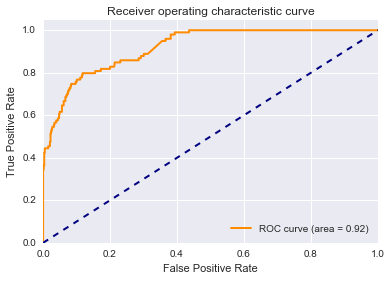

In [211]:
plt.figure()
plt.plot(x,y, color = 'darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

**Think**: what will happen if I change my spam threshold from 0.5?

**Think**: what decision rule are we using, when we assign the class label $\hat{y} = S$ when $P(S\,|\,X_1\dots X_n) = \frac{P(S)\prod_i P(X_i = x_i|S)}{P(\textbf{X})} > 0.5$

**Think**: what will happen if I split the data differently (e.g., less training data, more testing data). Try it!

We can also find words that lead to a high probability of spam (using Bayes' Theorem):

In [212]:
def p_spam_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_spam, prob_if_not_spam = word_prob
    return prob_if_spam / (prob_if_spam + prob_if_not_spam)

In [213]:
words = sorted(classifier.word_probs,key=p_spam_given_word)

In [214]:
spammiest_words = words[-15:]
hammiest_words = words[:15]

In [215]:
spammiest_words

[('doctor', 0.013580246913580247, 0.00021404109589041095),
 ('lender', 0.013580246913580247, 0.00021404109589041095),
 ('protect', 0.016049382716049384, 0.00021404109589041095),
 ('invest', 0.016049382716049384, 0.00021404109589041095),
 ('assist', 0.016049382716049384, 0.00021404109589041095),
 ('guarante', 0.018518518518518517, 0.00021404109589041095),
 ('rep', 0.018518518518518517, 0.00021404109589041095),
 ('norton', 0.018518518518518517, 0.00021404109589041095),
 ('account', 0.018518518518518517, 0.00021404109589041095),
 ('per', 0.020987654320987655, 0.00021404109589041095),
 ('clearanc', 0.02345679012345679, 0.00021404109589041095),
 ('zzzz', 0.025925925925925925, 0.00021404109589041095),
 ('systemwork', 0.030864197530864196, 0.00021404109589041095),
 ('money', 0.03580246913580247, 0.00021404109589041095),
 ('adv', 0.03827160493827161, 0.00021404109589041095)]

In [216]:
hammiest_words

[('spambay', 0.0012345679012345679, 0.046875),
 ('zzzzteana', 0.0012345679012345679, 0.0293236301369863),
 ('sadev', 0.0012345679012345679, 0.028039383561643837),
 ('ouch', 0.0012345679012345679, 0.025898972602739725),
 ('sell', 0.0012345679012345679, 0.021618150684931507),
 ('wed', 0.0012345679012345679, 0.020333904109589043),
 ('perl', 0.0012345679012345679, 0.01990582191780822),
 ('bliss', 0.0012345679012345679, 0.0194777397260274),
 ('satalk', 0.003703703703703704, 0.05372431506849315),
 ('window', 0.0012345679012345679, 0.01776541095890411),
 ('cvs', 0.0012345679012345679, 0.016481164383561644),
 ('bug', 0.0012345679012345679, 0.016053082191780824),
 ('apt', 0.0012345679012345679, 0.014768835616438356),
 ('java', 0.0012345679012345679, 0.014768835616438356),
 ('messag', 0.0012345679012345679, 0.014340753424657534)]

# Let' Try it on Our Clinton Obama Corpora

In [255]:
ObamaClintonReleases = pandas.read_csv("data/ObamaClintonReleases.csv")
ObamaClintonReleases = ObamaClintonReleases.dropna(axis=0, how='any')
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Let's turn the 'targetSenator' column into a binary variable.

In [256]:
ObamaClintonReleases['IsObama'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Let's split the data into training data and test data.

In [257]:
random.seed(0)
ObamaClintonReleases = ObamaClintonReleases.reindex(np.random.permutation(ObamaClintonReleases.index))
holdBackFraction = .25
holdBackIndex = int(holdBackFraction * len(ObamaClintonReleases))
train_data = ObamaClintonReleases[holdBackIndex:]
test_data = ObamaClintonReleases[:holdBackIndex]

In [258]:
print (len(train_data))
print (len(test_data))

1282
427


First, let's try with a logistic regression.
Turn the training dataset into a tf-idf matrix

In [221]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data['text'])

In [222]:
TFVects.shape

(1282, 11182)

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. Let's do a PCA. You have already seen it in week 3. Here we are less less concerned about visualization, so all principal components are calculated.

In [223]:
PCA = sklearn.decomposition.PCA
pca = PCA().fit(TFVects.toarray())
reduced_data = pca.transform(TFVects.toarray())

Visualization:

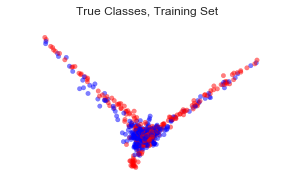

In [224]:
colordict = {
True: 'red',
False: 'blue',
    }
colors = [colordict[c] for c in train_data['IsObama']]
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Clinton from Obama well. Let's do a screeplot and see how many dimensions we need.

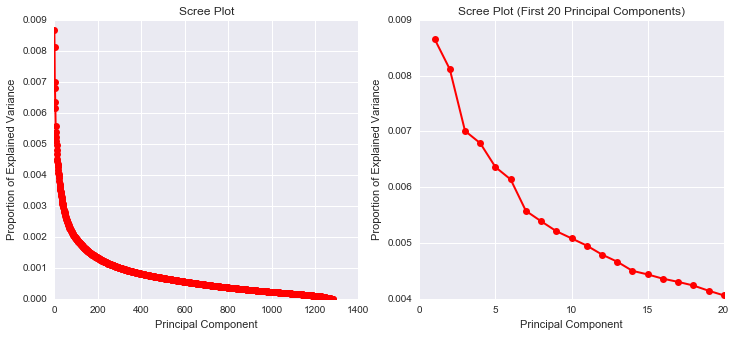

In [225]:
n = TFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [226]:
X = reduced_data[:, :10]

Transform our predictor variable. 

In [227]:
Y = np.array([int(label) for label in train_data['IsObama']])

Fit a logistic regression.

In [228]:
logistic = linear_model.LogisticRegression()
logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on our training dataset. The mean accuracy is only about 66%.

In [229]:
logistic.score(X,Y)

0.67238689547581898

How does it perform on the testing dataset?

In [259]:
TFVects_test = TFVectorizer.transform(test_data['text'])
reduced_data_test = pca.transform(TFVects_test.toarray())
X_test = reduced_data_test[:, :10]
Y_test = np.array([int(label) for label in test_data['IsObama']])
logistic.score(X_test, Y_test)

ValueError: X has 10 features per sample; expecting 400

Slightly Poorer. How about using more dimensions?

In [231]:
X = reduced_data[:, :40]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :40]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.723868954758
0.723653395785


In [232]:
X = reduced_data[:, :100]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :100]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.835413416537
0.814988290398


In [233]:
X = reduced_data[:, :200]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :200]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.876755070203
0.838407494145


In [234]:
X = reduced_data[:, :400]
logistic.fit(X, Y)
X_test = reduced_data_test[:, :400]
print(logistic.score(X,Y))
print(logistic.score(X_test, Y_test))

0.91263650546
0.847775175644


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 80%.

Or, we can use the original tf-idf matrix as our covariates and enforce an 'L1' penalty.

In [235]:
X = TFVects
logistic_l1= linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(X, Y)
print(logistic_l1.score(X,Y))

0.871294851794


Train the model using training data, and then test it on the testing data.

In [236]:
print(logistic_l1.score(TFVects_test,Y_test))

0.854800936768


80% accuracy seems like the best we can get by using a logistic regression. Let's try with Naive Bayes.

In [237]:
classifier = NaiveBayesClassifier()
classifier.train(train_data, 'IsObama', 'normalized_text')

In [238]:
classifier.word_probs

[('missil', 0.038461538461538464, 0.016644474034620507),
 ('scaap', 0.0009380863039399625, 0.003328894806924101),
 ('prayer', 0.03283302063789869, 0.02463382157123835),
 ('ford', 0.012195121951219513, 0.003328894806924101),
 ('dialysi', 0.0009380863039399625, 0.0019973368841544607),
 ('devot', 0.01594746716697936, 0.016644474034620507),
 ('mathematician', 0.0009380863039399625, 0.0019973368841544607),
 ('jerusalem', 0.0009380863039399625, 0.005992010652463382),
 ('carriag', 0.0028142589118198874, 0.0006657789613848203),
 ('kaczynski', 0.010318949343339587, 0.0006657789613848203),
 ('world', 0.3724202626641651, 0.4187749667110519),
 ('badland', 0.0028142589118198874, 0.0006657789613848203),
 ('chair', 0.021575984990619138, 0.07123834886817576),
 ('editori', 0.01594746716697936, 0.0006657789613848203),
 ('disincent', 0.0028142589118198874, 0.0006657789613848203),
 ('later', 0.08348968105065666, 0.05659121171770972),
 ('emt', 0.0028142589118198874, 0.0019973368841544607),
 ('email', 0.010

Let's evaluate the result on the test data.

In [262]:
classified = [(row['normalized_text'], row['IsObama'], classifier.classify(row['normalized_text']))
              for index, row in test_data.iterrows()]#It takes a while so do a subset

# assume that spam_probability > 0.5 corresponds to spam prediction # and count the combinations of (actual is_spam, predicted is_spam)
counts = collections.Counter((actual, predicted_probability > 0.5)
                     for text, actual, predicted_probability in classified)

counts

Counter({(False, False): 2, (False, True): 253, (True, True): 172})

Precision:

In [263]:
precision = counts[(True,True)]/(counts[(False,True)]+counts[(True,True)]) #True positives over all positive predictions
print(precision)

0.4047058823529412


Recall:

In [264]:
recall = counts[(True,True)]/(counts[(True,False)]+counts[(True,True)])#what fraction of positives identified
print(recall)

1.0


F-measure:

In [265]:
f_measure = 2 * (precision * recall)/(precision + recall)
print (f_measure)

0.576214405360134


In [266]:
df_classification = pandas.DataFrame(classified, columns = ['press release', 'is Obama', 'posterior probability'])
df_classification = df_classification.round(3)

Let's take a look at how well our posterior distribution is.

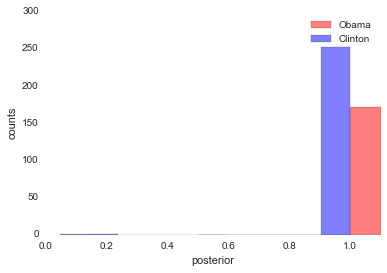

In [267]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(False)
ax1.set_frame_on(False)
df_classification[df_classification['is Obama'] == True]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Obama', color = 'red')
df_classification[df_classification['is Obama'] == False]['posterior probability'].hist(alpha = 0.5, ax = ax1, bins = 10, label = 'Clinton', color = 'blue')
ax1.set_xlim((0,1.1))
ax1.legend()
ax1.set_xlabel('posterior')
ax1.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate.

In [268]:
def p_obama_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities

    word, prob_if_obama, prob_if_not_obama = word_prob
    return prob_if_obama / (prob_if_obama + prob_if_not_obama)

In [269]:
words = sorted(classifier.word_probs,key=p_obama_given_word)

In [270]:
Obama_words = words[-15:]
Clinton_words = words[:15]

In [271]:
Obama_words

[('guarante', 0.015853658536585366, 0.0002145002145002145),
 ('rep', 0.015853658536585366, 0.0002145002145002145),
 ('lowest', 0.015853658536585366, 0.0002145002145002145),
 ('assist', 0.018292682926829267, 0.0002145002145002145),
 ('quot', 0.018292682926829267, 0.0002145002145002145),
 ('account', 0.018292682926829267, 0.0002145002145002145),
 ('clearanc', 0.020731707317073172, 0.0002145002145002145),
 ('protect', 0.020731707317073172, 0.0002145002145002145),
 ('invest', 0.020731707317073172, 0.0002145002145002145),
 ('per', 0.023170731707317073, 0.0002145002145002145),
 ('norton', 0.023170731707317073, 0.0002145002145002145),
 ('systemwork', 0.03048780487804878, 0.0002145002145002145),
 ('zzzz', 0.03048780487804878, 0.0002145002145002145),
 ('money', 0.032926829268292684, 0.0002145002145002145),
 ('adv', 0.042682926829268296, 0.0002145002145002145)]

In [272]:
Clinton_words

[('spambay', 0.0012195121951219512, 0.052123552123552123),
 ('zzzzteana', 0.0012195121951219512, 0.03238953238953239),
 ('sadev', 0.0012195121951219512, 0.026812526812526813),
 ('ouch', 0.0012195121951219512, 0.026812526812526813),
 ('problem', 0.0012195121951219512, 0.025954525954525954),
 ('sell', 0.0012195121951219512, 0.023809523809523808),
 ('wed', 0.0012195121951219512, 0.022093522093522094),
 ('bliss', 0.0012195121951219512, 0.021235521235521235),
 ('perl', 0.0012195121951219512, 0.020806520806520807),
 ('headlin', 0.0012195121951219512, 0.016945516945516947),
 ('satalk', 0.003658536585365854, 0.04997854997854998),
 ('java', 0.0012195121951219512, 0.016516516516516516),
 ('bug', 0.0012195121951219512, 0.016087516087516088),
 ('window', 0.0012195121951219512, 0.016087516087516088),
 ('kiddi', 0.0012195121951219512, 0.015229515229515229)]

## Multinomial Naive Bayes

Well suited to text applications, this generating model assumes that the features are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). Features might be, e.g., the count of various words in a text. 

Let's use again the dataset we used in week 3.

In [273]:
data = fetch_20newsgroups() #Free data to play with: documents from a newsgroup corpus.
data.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

This dataset has a built in breakdown into training and testing sets. We can pick specific categories, and pull the relevant training and testing sets. 

In [274]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [275]:
train['target']

array([2, 2, 1, ..., 2, 3, 1])

In [276]:
len(train.data) #See how many training examples

2153

In [277]:
len(test.data) #Ditto for testing -- it's about 60% training, 40% testing

1432

In [278]:
print(train.data[5]) #Look at an example
#print(train.target_names[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document but rarely across documents in the corpus (more distinctive). 

We also take advantage of a cool feature of Scikit-Learn: we can make pipelines...

In [279]:
model = make_pipeline(TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2'), MultinomialNB()) #This applies the vectorizer, then trains Multinomial NB

In [280]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [281]:
labels = model.predict(test.data)

In [282]:
labels.size

1432

We can even use a confusion matrix!

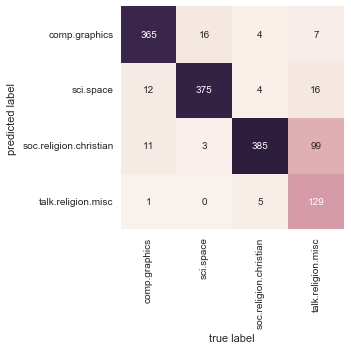

In [283]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [284]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.888801643276
0.875698324022
0.867534845252


Get the ROC curves.
First, we need to binarize the labels.

In [285]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform([1, 3]))

[0 1 2 3]
[[0 1 0 0]
 [0 0 0 1]]


In [286]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [287]:
n_classes = 4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

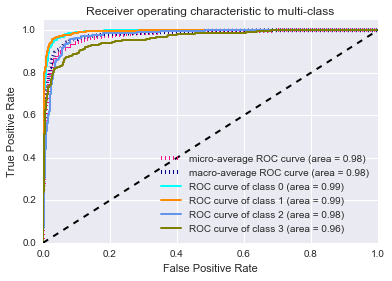

In [288]:
lw = 2
n_classes = 4
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and use the predict method to see if it can assign it to a category. This might be the main point of a social science application.

In [289]:
def predict_category(s, train=train, model=model): #We just define a simple function here
    return train.target_names[model.predict([s])]

In [290]:
#predict_category('rockets')

Try it yourself with your own strings!


**Playtime**: Try altering the categories! See if you can come up with ones that are more/less likely to be confused. As an extension, you can use different feature extractors, e.g., CountVectorizer. This just turns each document into a vector of word counts. 

## Now an a more relevant content analysis example

Now, let's add Bernie Sanders to our Obama Clinton dataset.

In [291]:
'''
#Unmark this section if you want to fetch press releases of a nother senator.
targetSenator = 'Sanders'

SandersReleases = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
SandersReleases =SandersReleases.append(targetDF, ignore_index = True)

ObamaClintonSandersReleases = ObamaClintonReleases.append(SandersReleases, ignore_index = True)
ObamaClintonSandersReleases.to_csv("data/ObamaClintonSandersReleases.csv")
'''

'\n#Unmark this section if you want to fetch press releases of a nother senator.\ntargetSenator = \'Sanders\'\n\nSandersReleases = pandas.DataFrame()\n\nprint("Fetching {}\'s data".format(targetSenator))\ntargetDF = getGithubFiles(\'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}\'.format(targetSenator), maxFiles = 2000)\ntargetDF[\'targetSenator\'] = targetSenator\nSandersReleases =SandersReleases.append(targetDF, ignore_index = True)\n\nObamaClintonSandersReleases = ObamaClintonReleases.append(SandersReleases, ignore_index = True)\nObamaClintonSandersReleases.to_csv("data/ObamaClintonSandersReleases.csv")\n'

In [292]:
ObamaClintonSandersReleases = pandas.read_csv("data/ObamaClintonSandersReleases.csv")
ObamaClintonSandersReleases = ObamaClintonSandersReleases.dropna(axis=0, how='any')

Let's split the data into training data and test data.

In [293]:
data = list(zip(ObamaClintonSandersReleases['text'], ObamaClintonSandersReleases['targetSenator']))
random.seed(0) #This is important for replicability
train_data,test_data = split_data(data,0.75)

In [294]:
print (len(train_data))
print (len(test_data))

1476
507


In [295]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [296]:
model.fit(train.data,train.target) #Training syntax: feed the fit method the training data and the training targets

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=100, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [297]:
labels = model.predict(test.data)

In [298]:
labels.size

507

In [299]:
model.classes_

array(['Clinton', 'Obama', 'Sanders'], 
      dtype='<U7')

Confusion matrix:

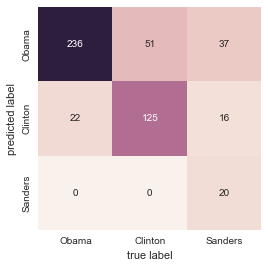

In [300]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

Let's get the precision, recall, and F-measure.

In [301]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.780858483391
0.751479289941
0.730628152246


Get the ROC curves.
First, we need to binarize the labels.

In [302]:
lb = preprocessing.LabelBinarizer()
lb.fit(test.target)
print(lb.classes_)
print(lb.transform(['Clinton', 'Obama']))

['Clinton' 'Obama' 'Sanders']
[[1 0 0]
 [0 1 0]]


In [303]:
y_test = lb.transform(test.target)
y_score = model.predict_proba(test.data)

In [304]:
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = sklearn.metrics.auc(fpr["micro"], tpr["micro"])

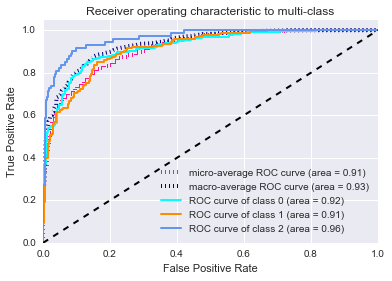

In [305]:
n_classes = 3
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] =  sklearn.metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

We can also give the model a string and using the predict method see if it can assign it to a category. This might be the main point of a social science application.

In [306]:
model.predict(['money'])

array(['Clinton'], 
      dtype='<U7')

In [307]:
model.predict(['Wall Street'])

array(['Clinton'], 
      dtype='<U7')

In [308]:
model.predict(['Chicago'])

array(['Obama'], 
      dtype='<U7')

# DECISION TREES

We are going to stick to Scikit-Learn here.

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

Let's create something to learn:

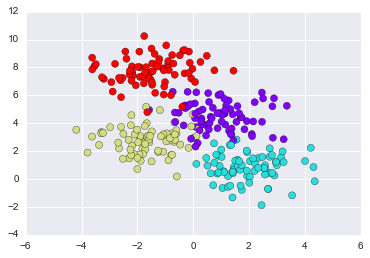

In [309]:
X, y = make_blobs(n_samples=300, centers=4,
                random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Now we import our Decision Tree classifier from sklearn.tree (very familiar syntax!) and fit it using the fit method.

In [310]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X,y)

To see what's going on visually with the classification, we can use this (complex) visualizer. 

In [311]:
def visualize_classifier(model, X, y, Xmod, ymod, ax=None, cmap='rainbow'): #X and y are plotted; Xmod and ymod train
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(Xmod, ymod)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)
    ax.set(xlim=xlim, ylim=ylim)

In [312]:
Xnew, ynew = make_blobs(n_samples=1000, centers=4,
                random_state=0, cluster_std=1.0)

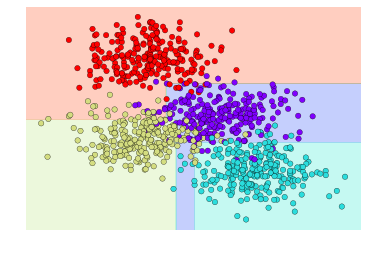

In [313]:
visualize_classifier(DecisionTreeClassifier(max_depth=4,random_state=0), Xnew, ynew, X, y) #We train on the full data

In [314]:
accuracy_score(ynew,DecisionTreeClassifier(max_depth=10,random_state=0).fit(X,y).predict(Xnew))

0.91400000000000003

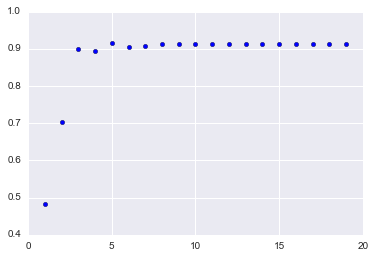

In [315]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X,y)
    score = accuracy_score(ynew,tree2.predict(Xnew))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)

Near the cluster boundaries, the shape is pretty weird. Overfitting!

In [316]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5,random_state=1) #test_size means a 50/50 split
print(len(X))
print(len(Xtrain))
print(len(Xtest))

300
150
150


With some abuse of notation, we can use the visualizer to plot first a classifier trained on the "training" half of the data.

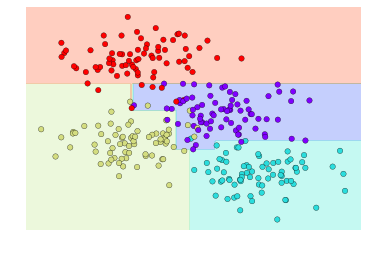

In [317]:
visualize_classifier(DecisionTreeClassifier(max_depth=5,random_state=0), X, y, Xtrain, ytrain) #Train with half the data

Now we can train on the second half of the data--allegedly the test data--to see how different training sets affect the decision boundaries.

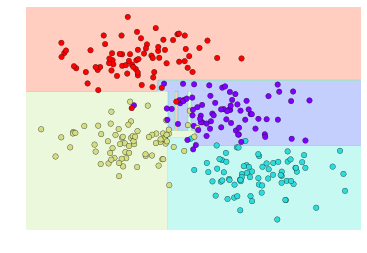

In [318]:
visualize_classifier(DecisionTreeClassifier(random_state=0), X, y, Xtest, ytest) #Train with other half of the data

Finally, we can get a sense of the performance by training on the training data, but PLOTTING the test data

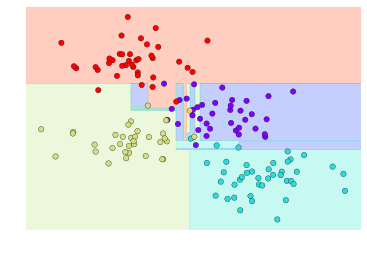

In [319]:
visualize_classifier(DecisionTreeClassifier(), Xtest, ytest, Xtrain, ytrain) #Trains with train data, plots test data

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [320]:
tree = DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [321]:
#?BaggingClassifier #Learn more

In [322]:
bag.fit(X,y) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [323]:
Xnew, ynew = make_blobs(n_samples=10000, centers=4,
                random_state=0, cluster_std=1.0)

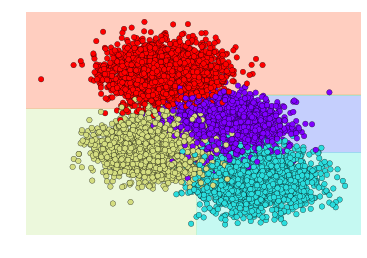

In [324]:
visualize_classifier(bag,Xnew,ynew,X,y) #And visualize
#Remember we can give the full data as training data, as bag automatically splits and trains

In [325]:
recall_score(ynew,bag.predict(Xnew),average='weighted')

0.9204

# Let's try it on the Clinton Obama Sanders dataset.

In [326]:
TFVects = TFVectorizer.fit_transform(train.data)

In [327]:
tree = DecisionTreeClassifier(max_depth=4,random_state=0).fit(TFVects,train.target)

In [328]:
TFVects_test = TFVectorizer.transform(test.data)

In [329]:
labels = tree.predict(TFVects_test)

Confusion matrix:

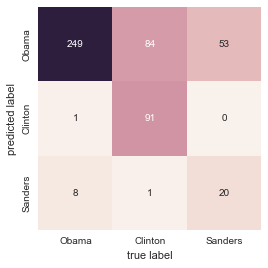

In [330]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [331]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.770930642843
0.710059171598
0.685718256036


Not really better than Multinomial Naive Bayes. Let's try a random forest.

In [332]:
bag.fit(TFVects,train.target) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [333]:
labels = bag.predict(TFVects_test)

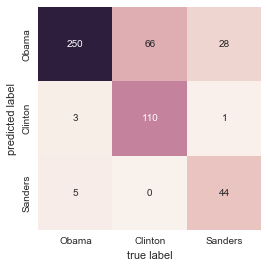

In [334]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [335]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.834074125861
0.79684418146
0.789859355759


The performance is better!

## Brief aside: Random forest regression (Optional)

First, let's create a challenging dataset.

In [336]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200) #200 uniformly distributed random numbers between 0 and 10
def model(x, sigma=0.3): 
    fast_oscillation = np.sin(5 * x) 
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x)) #Create 200 random numbers, normally distributed

    return slow_oscillation + fast_oscillation + noise

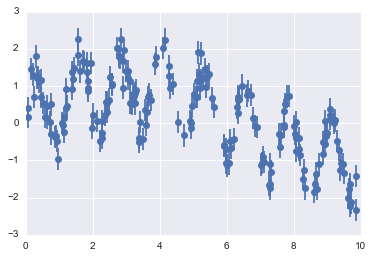

In [337]:
y = model(x)
plt.errorbar(x, y, 0.3, fmt='o'); #Shows one std around point
#plt.scatter(x, y); #Plots the actual points

First we will try to learn this with something simple; a single decision tree, but one that is a regressor, not a classifier.

In [338]:
#First try to learn this with something simple --  a single decision tree regressor

# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(x[:,None], y)
regr_2.fit(x[:,None], y)
regr_3.fit(x[:,None], y)

# Predict
xfit = np.linspace(0, 10, 1000)
yfit_1 = regr_1.predict(xfit[:, None]) #xfit[:,None] is a work-around to pass a 1d feature matrix
yfit_2 = regr_2.predict(xfit[:, None])
yfit_3 = regr_3.predict(xfit[:, None])

Let's see how these two decision trees do... What do you think will happen as we add depth?

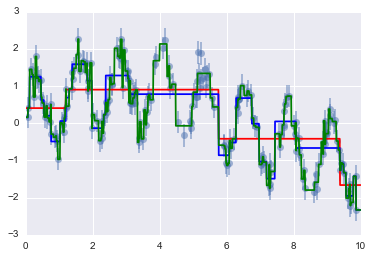

In [339]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit_1, '-r'); #depth = 2
plt.plot(xfit,yfit_2,'-b'); #depth = 5
plt.plot(xfit,yfit_3,'-g'); #depth = 10

Or we can use a **random forest regressor**

In [340]:
forest = RandomForestRegressor(200) 
forest.fit(x[:, None], y)
    
yfit = forest.predict(xfit[:, None]) #Predictions of the forest model
ytrue = model(xfit, sigma=0) #This is the underlying data, no noise

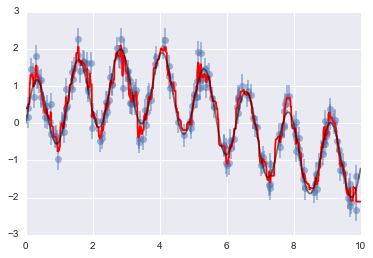

In [341]:
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

A beautiful fit of the underlying pattern... a lot of the noise has been washed out. This is the power of bagging.

# K-Nearest Neighbors

Let's use newsgroup data again.

In [342]:
categories = ['soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Let's visualize it using PCA.

In [343]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train.data)

In [344]:
TFVects.shape

(1776, 11107)

In [345]:
pca = PCA(n_components= 2)
reduced_data = pca.fit_transform(TFVects.toarray())

In [346]:
train.target_names

['comp.graphics', 'sci.space', 'soc.religion.christian']

Visualization:

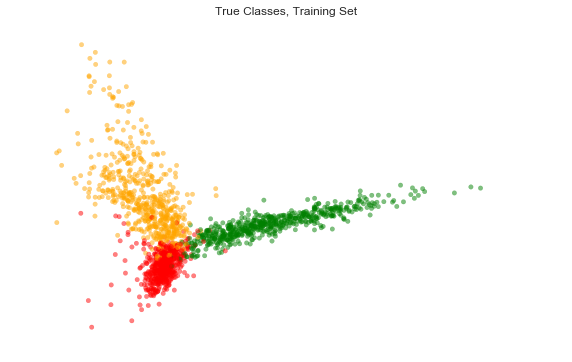

In [347]:
colordict = {
0: 'red',
1: 'orange',
2: 'green',
    }
colors = [colordict[c] for c in train.target]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes, Training Set')
plt.show()

Let's initialize our k-nearest neighbors classifier.

In [348]:
n_neighbors = 15
weights="uniform"
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

For visualization purpopose, let's first try applying the k-nearest neighbors classifier to the projected data.

In [349]:
clf.fit(reduced_data, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [350]:
TFVects_test = TFVectorizer.transform(test.data)
reduced_data_test = pca.transform(TFVects_test.toarray())

In [351]:
labels = clf.predict(reduced_data_test)

Confusion matrix:

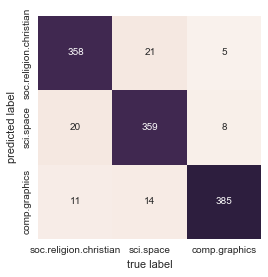

In [353]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

The precision, recall, and F-measure.

In [354]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.933011605167
0.933107535986
0.932951313439


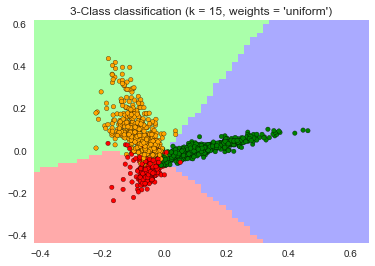

In [355]:
h = .02  # step size in the mesh
# Create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = reduced_data[:, 0].min() - 0.2, reduced_data[:, 0].max() + 0.2
y_min, y_max = reduced_data[:, 1].min() - 0.2, reduced_data[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colors, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
          % (n_neighbors, weights))

plt.show()

Let's use the full tf-idf matrix instead.

In [356]:
clf.fit(TFVects, train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [357]:
labels = clf.predict(TFVects_test)

Confusion matrix:

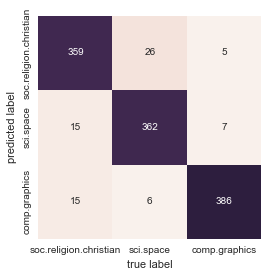

In [358]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

Small improvement. In this case, PCA reduced the dimensionality of the data without loosing too much informatin.
Finally, let's use it again on the Obama Clinton Sanders dataset.

In [359]:
train.data = [data[0] for data in train_data]
train.target = [data[1] for data in train_data]
test.data = [data[0] for data in test_data]
test.target = [data[1] for data in test_data]

In [360]:
TFVects_OCS = TFVectorizer.fit_transform(train.data)
TFVects_OCS_test = TFVectorizer.transform(test.data)

In [361]:
clf.fit(TFVects_OCS,train.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [362]:
labels = clf.predict(TFVects_OCS_test)

Confusion matrix:

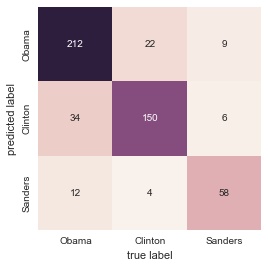

In [364]:
mat = confusion_matrix(test.target, labels)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Obama', 'Clinton', 'Sanders'], yticklabels=['Obama', 'Clinton', 'Sanders'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [365]:
print(sklearn.metrics.precision_score(test.target, labels, average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test.target, labels, average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test.target, labels, average = 'weighted')) #F-1 measure

0.830867858758
0.828402366864
0.828826514099


# SVMs

Now we will examine Support Vector Machines, using a few sub forums from reddit, namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [16]:
redditDf = pandas.read_csv('data/reddit.csv')

#Drop a couple missing values

redditDf = redditDf.dropna()

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

TF-idf it to make the vectors

In [17]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['tfVect'] = [np.array(v) for v in redditTFVects.todense()]
redditDf['tfVect'][:5]

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: tfVect, dtype: object

In [18]:
redditDf['tfVect'][0].shape

(1, 9573)

Initilize the model

In [19]:
clf = sklearn.svm.SVC(kernel='linear', probability = True)
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Setup a training set

In [20]:
random.seed(0)
shuffled_redditDf = redditDf.reindex(np.random.permutation(redditDf.index))
holdBackFraction = .2
holdBackIndex = int(holdBackFraction * len(shuffled_redditDf))
training_redditDf = redditDf[holdBackIndex: ].reset_index()
test_redditDf = redditDf[:holdBackIndex]

Fit the model

In [ ]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

Here's the 4 classes

In [ ]:
clf.classes_

And a predition from the testing set

In [ ]:
print(clf.predict_proba(test_redditDf['tfVect'][11]))
print(clf.predict(test_redditDf['tfVect'][11]))
print(test_redditDf['subreddit'][11])

In [25]:
redditDf['svc'] = [clf.predict(v)[0] for v in redditDf['tfVect']]

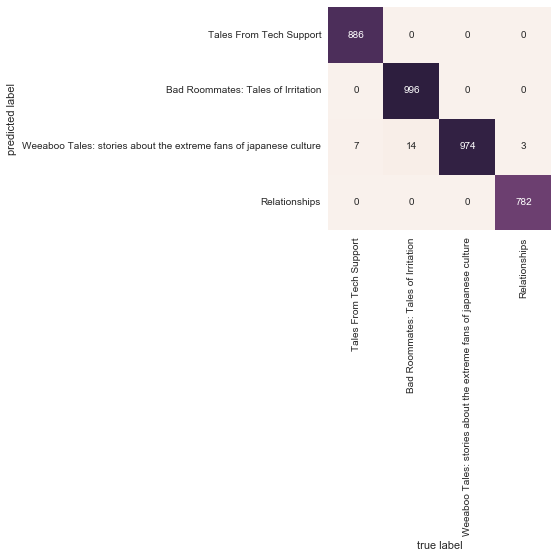

In [29]:
mat = confusion_matrix(redditDf['svc'], redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

# Neural Nets

In [21]:
clf = MLPClassifier()
clf

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [22]:
clf.fit(np.stack(training_redditDf['tfVect'], axis=1)[0], training_redditDf['subreddit'].as_matrix())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [23]:
clf.classes_

array(['Bad Roommates: Tales of Irritation', 'Relationships',
       'Tales From Tech Support',
       'Weeaboo Tales: stories about the extreme fans of japanese culture'], 
      dtype='<U65')

In [24]:
print(clf.predict_proba(test_redditDf['tfVect'][11]))
print(clf.predict(test_redditDf['tfVect'][11]))
print(test_redditDf['subreddit'][11])

[[ 0.0088603   0.00261618  0.97868861  0.00983491]]
['Tales From Tech Support']
Tales From Tech Support


In [27]:
redditDf['MLP'] = [clf.predict(v)[0] for v in redditDf['tfVect']]

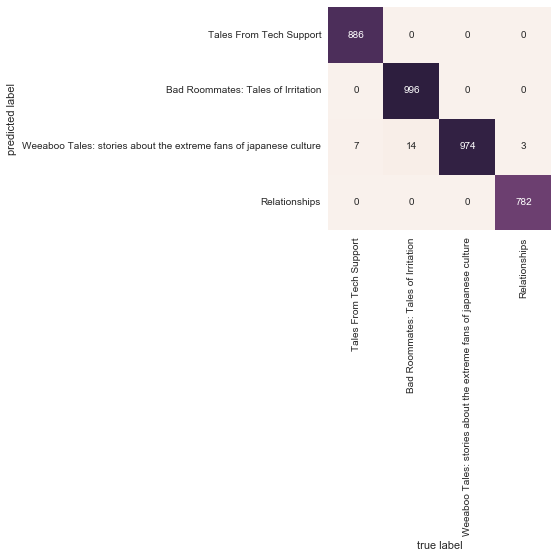

In [28]:
mat = confusion_matrix(redditDf['MLP'], redditDf['subreddit'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=redditDf['subreddit'].unique(), yticklabels=redditDf['subreddit'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')